In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [82]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")
conn = engine.connect()

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [78]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [58]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [59]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
tmin_tmax_tavg = calc_temps('2016-08-01','2017-08-01')
tmin_tmax_tavg

[(58.0, 74.64288840262581, 87.0)]

In [60]:
tmin = tmin_tmax_tavg[0][0]
tavg = tmin_tmax_tavg[0][1]
tmax = tmin_tmax_tavg[0][2]

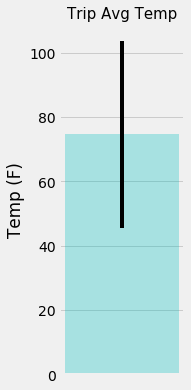

In [61]:
# Plot the results from your previous query as a bar chart. 
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
PTP = tmax-tmin
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
plt.figure(figsize=(2,6))
plt.bar(0,tavg, yerr=PTP, align='center',color="c",alpha=0.3)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.title("Trip Avg Temp", fontsize= 15)
plt.show()

### Daily Rainfall Average

In [99]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
result = pd.read_sql("SELECT s.station,s.name,s.latitude,s.longitude,s.elevation,sum(m.prcp) as 'rainfall'\
                            FROM station as s\
                            JOIN measurement as m ON(s.station = m.station)\
                            WHERE m.date\
                            BETWEEN '2016-08-01' AND '2017-08-01'\
                            GROUP BY s.station\
                            ORDER BY SUM(m.prcp) DESC" , conn)
result.head()

,station,name,latitude,longitude,elevation,rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,157.91
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,79.49
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,54.39
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,39.80
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,34.26


In [100]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [125]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
# Use the `daily_normals` function to calculate the normals for each date string 
delta = dt.datetime.strptime(start_date, "%Y-%m-%d") - dt.datetime.strptime(end_date,"%Y-%m-%d")
dates = []
normals = []
for x in range(delta.days+1):
    date = dt.date.strptime(start_date, "%Y-%m-%d") + dt.timedelta(days= x)
    dates.append(dt.datetime.strptime(date, "%Y-%m-%d"))
    tmin,tavg,tmax = np.ravel(daily_normals(dt.datetime.strftime(date, "%m-%d")))
    normals.append((tmin,tavg,tmax))


In [131]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df = df.set_index(dates)


ValueError: Must pass non-zero number of levels/codes

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session